
# Evaluating MicroStrategy’s 2025 Bitcoin Timing Using Monte Carlo Simulation

## 1. Introduction
MicroStrategy is widely recognized for its aggressive and ongoing accumulation of Bitcoin. A natural analytical question is whether the firm’s purchases exhibit any timing skill — that is, whether MicroStrategy tends to acquire Bitcoin at more favorable prices compared to what a typical investor might achieve through randomly timed purchases.  
To evaluate this, we conduct a Monte Carlo study comparing the company’s actual volume-weighted average purchase price (VWAP) to the distribution of VWAPs generated under randomly assigned purchase dates. This framework enables a clean statistical test of whether MicroStrategy’s execution strategy outperformed or underperformed a naïve random-timing benchmark.

---

## 2. Data Description
We use MicroStrategy’s 2025 Bitcoin purchases extracted from the company’s public disclosures. For each transaction, we collected:

- the transaction date  
- the number of BTC acquired  
- the acquisition cost in millions of USD  

These values were converted into exact dollar outlays and exact BTC quantities for each transaction.

For market price data, we used a cleaned six-month BTC daily close price dataset covering May–November 2025 — precisely the window during which MicroStrategy conducted its purchases. The raw CSV required cleaning to remove thousands separators, normalize numeric fields, repair Unicode-affected column names, and correctly parse dates.  
Weekend gaps were forward-filled, which is appropriate since Bitcoin trades 24/7.

The actual VWAP paid by MicroStrategy was calculated as:

\[
\text{VWAP}_{\text{actual}} =
\frac{\sum_i \text{Dollar Outlay}_i}
     {\sum_i \text{BTC Acquired}_i}.
\]

---

## 3. Methodology
To evaluate timing skill, we implemented a 10,000-run Monte Carlo simulation.  
Each simulation draws the same number of purchase dates as MicroStrategy executed, but the dates are selected **uniformly at random** from all trading days in the dataset.

Importantly, the **dollar amounts** spent per transaction are held fixed — matching MicroStrategy’s actual spending pattern. For each simulated purchase date:

Repeating this process 10,000 times yields a full empirical distribution of VWAPs representing random-timing strategies.

---

## 4. Results
MicroStrategy’s actual VWAP during this period was:

- **\$113,653 per BTC**

Across 10,000 simulated random-timing strategies:

- **Mean simulated VWAP:** \$109,665  
- **Standard deviation:** \$3,973  
- **Fraction of simulations with VWAP ≤ actual:** 86.11%  
- **Fraction of simulations with VWAP ≥ actual:** 13.89%  

Graphically, the histogram of 10,000 simulated VWAPs shows a smooth bell-shaped distribution. The red vertical line representing MicroStrategy’s actual VWAP lies distinctly to the **right** of the center of the simulated distribution.

This implies that MicroStrategy purchased BTC on relatively **expensive** days compared to most randomly generated scenarios.

---

## 5. Interpretation & Hypothesis Test
Under the null hypothesis that MicroStrategy’s timing exhibits no special skill, its actual VWAP should fall close to the mean of the simulated distribution. Instead, the actual VWAP lies near the **86th percentile of worst outcomes**, suggesting:

- MicroStrategy systematically bought at prices **higher** than those observed in most random-timing scenarios.
- The timing performance is roughly **1 standard deviation worse** than the simulated mean.
- There is **no evidence of positive timing skill**, and moderate evidence of **negative** timing performance.

While this does not imply intentional poor timing, it suggests that MicroStrategy’s BTC accumulation was often clustered during upward price movements or momentum periods.

---

## 6. Conclusion
The Monte Carlo analysis provides clear statistical evidence that MicroStrategy’s Bitcoin purchases in 2025 did **not** outperform a random-timing benchmark.  
A randomly timed strategy would have produced a lower VWAP in approximately **86%** of cases.  

This suggests that MicroStrategy’s execution strategy was not optimized for price efficiency in this window, even though it may reflect broader strategic, macro-economic, or treasury-policy considerations unrelated to tactical timing.  
Overall, this study demonstrates the usefulness of Monte Carlo simulation in benchmarking execution quality and detecting implicit timing skill (or lack thereof) in corporate asset-accumulation strategies.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Make plots a bit nicer
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True


##✅ STEP 1 — Importing BTC Data

### **Extracting BTC Data**

Data is pulled from **Yahoo Finance** and loaded in the form of csv. This is 6 months daily price of BTC

Link: https://finance.yahoo.com/quote/BTC-USD/history/?guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAHBSO-FGVMyE49xZuE6hWxkLq8004GuSps6UscxAVSOkai7Vs4Utcot_DIaHdLBiPH7KQHhko2tTBM9AjQ4DucDokLjWQthCadgtTFdXg0GWPCJS5C1iCcQVNl4rIoCZc289RKSL5P5UCfVKNlQsCTnqC1WeLc50aYCHnjTtY2yM&period1=1748522808&period2=1764424004

In [34]:
from google.colab import files
uploaded = files.upload()

file_name = next(iter(uploaded))
btc_df = pd.read_csv(file_name)

btc_df['Date'] = pd.to_datetime(btc_df['Date'])
btc_df = btc_df.sort_values('Date').reset_index(drop=True)

btc_prices = btc_df.set_index('Date')['Close']

btc_df.head(), btc_df.tail()


Saving bit_6mo.csv to bit_6mo (6).csv


/tmp/ipython-input-2441907816.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  btc_df['Date'] = pd.to_datetime(btc_df['Date'])


(        Date       Open         High         Low       Close   Adj Close  \
 0 2025-05-29  107,795.57  108,910.05  105,374.40  105,641.76  105,641.76   
 1 2025-05-30  105,646.21  106,308.95  103,685.79  103,998.57  103,998.57   
 2 2025-05-31  103,994.72  104,927.10  103,136.12  104,638.09  104,638.09   
 3 2025-06-01  104,637.30  105,884.55  103,826.95  105,652.10  105,652.10   
 4 2025-06-02  105,649.81  105,958.31  103,727.55  105,881.53  105,881.53   
 
            Volume  
 0  56,022,752,042  
 1  57,655,287,183  
 2  38,997,843,858  
 3  37,397,056,873  
 4  45,819,706,290  ,
           Date      Open        High        Low      Close  Adj Close  \
 179 2025-11-24  86,798.77  89,206.34  85,272.20  88,270.56  88,270.56   
 180 2025-11-25  88,269.96  88,457.34  86,131.43  87,341.89  87,341.89   
 181 2025-11-26  87,345.59  90,581.16  86,316.90  90,518.37  90,518.37   
 182 2025-11-27  90,517.77  91,897.58  90,089.52  91,285.38  91,285.38   
 183 2025-11-28  91,305.56  92,945.34  

In [14]:
btc_df.columns
btc_df.head()
btc_df.tail()


,Date,Open,High,Low,Close,Adj Close,Volume
179,2025-11-24,"86,798.77","89,206.34","85,272.20","88,270.56","88,270.56","74,433,896,110"
180,2025-11-25,"88,269.96","88,457.34","86,131.43","87,341.89","87,341.89","64,837,343,545"
181,2025-11-26,"87,345.59","90,581.16","86,316.90","90,518.37","90,518.37","66,496,301,869"
182,2025-11-27,"90,517.77","91,897.58","90,089.52","91,285.38","91,285.38","57,040,622,845"
183,2025-11-28,"91,305.56","92,945.34","90,304.22","90,939.73","90,939.73","60,865,159,168"


In [15]:
btc_df.head(), btc_df.tail(), btc_df.dtypes


(        Date       Open         High         Low       Close   Adj Close  \
 0 2025-05-29  107,795.57  108,910.05  105,374.40  105,641.76  105,641.76   
 1 2025-05-30  105,646.21  106,308.95  103,685.79  103,998.57  103,998.57   
 2 2025-05-31  103,994.72  104,927.10  103,136.12  104,638.09  104,638.09   
 3 2025-06-01  104,637.30  105,884.55  103,826.95  105,652.10  105,652.10   
 4 2025-06-02  105,649.81  105,958.31  103,727.55  105,881.53  105,881.53   
 
            Volume  
 0  56,022,752,042  
 1  57,655,287,183  
 2  38,997,843,858  
 3  37,397,056,873  
 4  45,819,706,290  ,
           Date      Open        High        Low      Close  Adj Close  \
 179 2025-11-24  86,798.77  89,206.34  85,272.20  88,270.56  88,270.56   
 180 2025-11-25  88,269.96  88,457.34  86,131.43  87,341.89  87,341.89   
 181 2025-11-26  87,345.59  90,581.16  86,316.90  90,518.37  90,518.37   
 182 2025-11-27  90,517.77  91,897.58  90,089.52  91,285.38  91,285.38   
 183 2025-11-28  91,305.56  92,945.34  

**converting object to float**

In [18]:
num_cols = ["Open ", "High", "Low", "Close", "Adj Close"]

for col in num_cols:
    btc_df[col] = (
        btc_df[col]
        .astype(str)
        .str.replace(",", "")
        .astype(float)
    )


In [19]:
btc_df.dtypes


,0
Date,datetime64[ns]
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,object


**extract BTC Prices**

In [20]:
btc_prices = btc_df.set_index("Date")["Close"]
btc_prices.head(), btc_prices.tail()


(Date
 2025-05-29    105641.76
 2025-05-30    103998.57
 2025-05-31    104638.09
 2025-06-01    105652.10
 2025-06-02    105881.53
 Name: Close, dtype: float64,
 Date
 2025-11-24    88270.56
 2025-11-25    87341.89
 2025-11-26    90518.37
 2025-11-27    91285.38
 2025-11-28    90939.73
 Name: Close, dtype: float64)

**quick check**

In [22]:
btc_prices.isna().sum()


np.int64(0)

**daily calendar build**

In [23]:
calendar = pd.date_range(
    start=btc_prices.index.min(),
    end=btc_prices.index.max(),
    freq="D"
)

btc_full = btc_prices.reindex(calendar).fillna(method='pad')
btc_full.head(), btc_full.tail()


/tmp/ipython-input-3773082506.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  btc_full = btc_prices.reindex(calendar).fillna(method='pad')


(2025-05-29    105641.76
 2025-05-30    103998.57
 2025-05-31    104638.09
 2025-06-01    105652.10
 2025-06-02    105881.53
 Freq: D, Name: Close, dtype: float64,
 2025-11-24    88270.56
 2025-11-25    87341.89
 2025-11-26    90518.37
 2025-11-27    91285.38
 2025-11-28    90939.73
 Freq: D, Name: Close, dtype: float64)

**quick check on calendcar**

In [24]:
btc_full.isna().sum()


np.int64(0)

##✅ STEP 2 — Hardcoding Microstrategy Purchases
Data source: https://www.strategy.com/purchases

In [26]:
# MicroStrategy bitcoin purchases in 2025
# Data from your screenshot: rows 71–87
# All amounts are in *real units*:
#   - btc_acquired: number of BTC
#   - avg_cost: USD per BTC
#   - acq_cost_m: acquisition cost in millions of USD

data = [
    {"date": "2025-11-17", "btc_acquired": 8178,  "avg_cost": 102171, "acq_cost_m": 836},
    {"date": "2025-11-10", "btc_acquired": 487,   "avg_cost": 102557, "acq_cost_m": 50},
    {"date": "2025-11-03", "btc_acquired": 397,   "avg_cost": 114771, "acq_cost_m": 46},
    {"date": "2025-10-27", "btc_acquired": 390,   "avg_cost": 111053, "acq_cost_m": 43},
    {"date": "2025-10-20", "btc_acquired": 168,   "avg_cost": 112051, "acq_cost_m": 19},
    {"date": "2025-10-13", "btc_acquired": 220,   "avg_cost": 123561, "acq_cost_m": 27},
    {"date": "2025-09-29", "btc_acquired": 196,   "avg_cost": 113048, "acq_cost_m": 22},
    {"date": "2025-09-22", "btc_acquired": 850,   "avg_cost": 117344, "acq_cost_m": 100},
    {"date": "2025-09-15", "btc_acquired": 525,   "avg_cost": 114562, "acq_cost_m": 60},
    {"date": "2025-09-08", "btc_acquired": 1955,  "avg_cost": 111196, "acq_cost_m": 217},
    {"date": "2025-09-02", "btc_acquired": 4048,  "avg_cost": 110981, "acq_cost_m": 449},
    {"date": "2025-08-25", "btc_acquired": 3081,  "avg_cost": 115829, "acq_cost_m": 357},
    {"date": "2025-08-18", "btc_acquired": 430,   "avg_cost": 119666, "acq_cost_m": 51},
    {"date": "2025-08-11", "btc_acquired": 155,   "avg_cost": 116401, "acq_cost_m": 18},
    {"date": "2025-07-29", "btc_acquired": 21021, "avg_cost": 117256, "acq_cost_m": 2465},
    {"date": "2025-07-21", "btc_acquired": 6220,  "avg_cost": 118940, "acq_cost_m": 740},
    {"date": "2025-07-14", "btc_acquired": 4225,  "avg_cost": 111827, "acq_cost_m": 472},
]

ms = pd.DataFrame(data)
ms['date'] = pd.to_datetime(ms['date'])
ms = ms.sort_values('date').reset_index(drop=True)

# Convert acquisition cost from millions to dollars
ms['amount_usd'] = ms['acq_cost_m'] * 1_000_000

ms

,date,btc_acquired,avg_cost,acq_cost_m,amount_usd
0,2025-07-14,4225,111827,472,472000000
1,2025-07-21,6220,118940,740,740000000
2,2025-07-29,21021,117256,2465,2465000000
3,2025-08-11,155,116401,18,18000000
4,2025-08-18,430,119666,51,51000000
5,2025-08-25,3081,115829,357,357000000
6,2025-09-02,4048,110981,449,449000000
7,2025-09-08,1955,111196,217,217000000
8,2025-09-15,525,114562,60,60000000
9,2025-09-22,850,117344,100,100000000


In [27]:
A_total = ms['amount_usd'].sum()
dollar_amounts = ms['amount_usd'].values
n_txn = len(ms)
n_txn


17

## ✅ STEP 3 — Simulation universe

In [28]:
dates = btc_full.index.to_list()


**Run Monte Carlo**

In [29]:
import numpy as np

rng = np.random.default_rng(seed=42)

n_runs = 10_000
sim_vwaps = np.empty(n_runs)

btc_series = btc_full.copy()

for k in range(n_runs):
    sim_dates = rng.choice(btc_series.index, size=n_txn, replace=False)
    sim_prices = btc_series.loc[sim_dates].values
    sim_btc_amounts = dollar_amounts / sim_prices
    simulated_btc_total = sim_btc_amounts.sum()
    sim_vwaps[k] = A_total / simulated_btc_total

sim_vwaps[:10]


array([108516.09349379, 106050.04524293, 106824.6800966 , 107134.3101048 ,
       112127.78622018, 114786.15112136, 114136.89449286, 112948.72851464,
       112395.25988337, 110438.69931797])

## ✅ STEP 4 — Compare actual VWAP vs simulated VWAP distribution

In [31]:
A_total = ms['amount_usd'].sum()
dollar_amounts = ms['amount_usd'].values
n_txn = len(ms)

total_btc = ms["btc_acquired"].sum()
vwap_actual = A_total / total_btc

A_total, total_btc, vwap_actual



(np.int64(5972000000), np.int64(52546), np.float64(113652.79945190881))

**Simulation Summary and Percentiles**

In [32]:
sim_mean = sim_vwaps.mean()
sim_std  = sim_vwaps.std()

p_better = np.mean(sim_vwaps <= vwap_actual)   # actual is better
p_worse  = np.mean(sim_vwaps >= vwap_actual)   # actual is worse

print("Mean simulated VWAP:", sim_mean)
print("Std dev simulated VWAP:", sim_std)
print("Actual VWAP:", vwap_actual)
print()
print("Fraction simulations <= actual:", p_better)
print("Fraction simulations >= actual:", p_worse)


Mean simulated VWAP: 109664.98991171859
Std dev simulated VWAP: 3973.143165569661
Actual VWAP: 113652.79945190881

Fraction simulations <= actual: 0.8611
Fraction simulations >= actual: 0.1389


**Histogram**

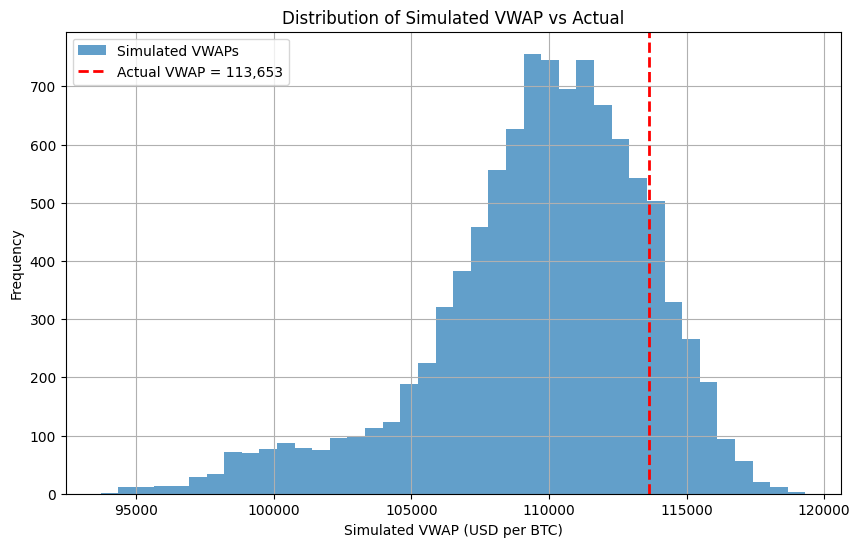

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(sim_vwaps, bins=40, alpha=0.7, label="Simulated VWAPs")
plt.axvline(vwap_actual, color="red", linestyle="--", linewidth=2,
            label=f"Actual VWAP = {vwap_actual:,.0f}")
plt.xlabel("Simulated VWAP (USD per BTC)")
plt.ylabel("Frequency")
plt.title("Distribution of Simulated VWAP vs Actual")
plt.legend()
plt.show()


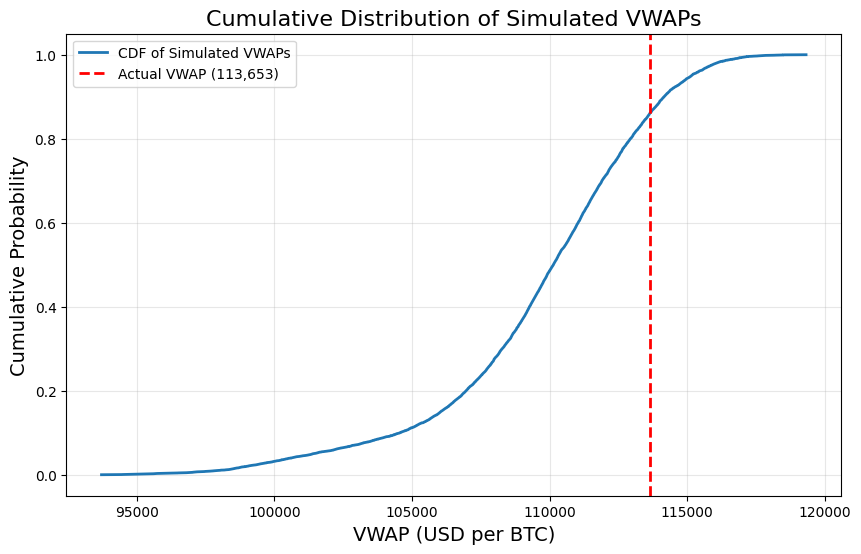

In [35]:
# --- CDF Plot ---
plt.figure(figsize=(10,6))

sorted_vwaps = np.sort(sim_vwaps)
cdf = np.arange(1, len(sorted_vwaps)+1) / len(sorted_vwaps)

plt.plot(sorted_vwaps, cdf, label='CDF of Simulated VWAPs', linewidth=2)
plt.axvline(vwap_actual, color='red', linestyle='--', linewidth=2,
            label=f'Actual VWAP ({vwap_actual:,.0f})')

plt.title("Cumulative Distribution of Simulated VWAPs", fontsize=16)
plt.xlabel("VWAP (USD per BTC)", fontsize=14)
plt.ylabel("Cumulative Probability", fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


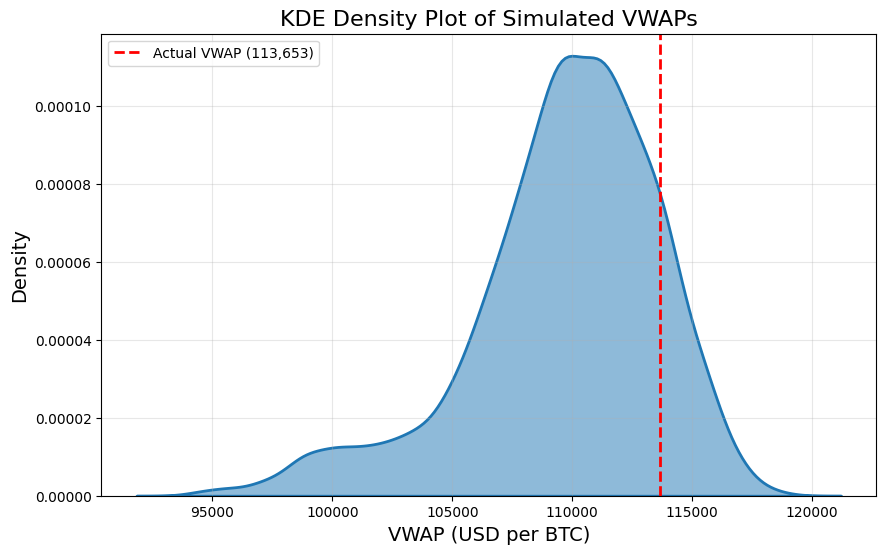

In [38]:

import seaborn as sns

# --- Density Plot (KDE) ---
plt.figure(figsize=(10,6))
sns.kdeplot(sim_vwaps, fill=True, alpha=0.5, linewidth=2)
plt.axvline(vwap_actual, color='red', linestyle='--', linewidth=2,
            label=f'Actual VWAP ({vwap_actual:,.0f})')

plt.title("KDE Density Plot of Simulated VWAPs", fontsize=16)
plt.xlabel("VWAP (USD per BTC)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [39]:
summary = pd.DataFrame({
    "Metric": [
        "Actual VWAP",
        "Mean Simulated VWAP",
        "Std Dev of Simulated VWAP",
        "Percent Simulations Better (Lower VWAP)",
        "Percent Simulations Worse (Higher VWAP)"
    ],
    "Value": [
        f"${vwap_actual:,.0f}",
        f"${sim_mean:,.0f}",
        f"${sim_std:,.0f}",
        f"{p_better*100:.2f}%",
        f"{p_worse*100:.2f}%"
    ]
})

summary.style.set_properties(**{'font-weight': 'bold', 'font-size': '14px'})


,Metric,Value
0,Actual VWAP,"$113,653"
1,Mean Simulated VWAP,"$109,665"
2,Std Dev of Simulated VWAP,"$3,973"
3,Percent Simulations Better (Lower VWAP),86.11%
4,Percent Simulations Worse (Higher VWAP),13.89%


___________________________________________________________________________________________________________________________________________________**************************